# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


#  Chapter 7

In [10]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [11]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [12]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [13]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [14]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

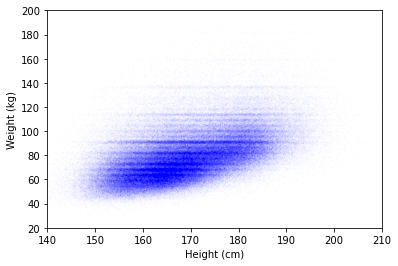

In [15]:
# Solution goes here
# With smaller markers, I needed more aggressive jittering to
# blur the measurement artifacts

# With this dataset, using all of the rows might be more trouble
# than it's worth.  Visualizing a subset of the data might be
# more practical and more effective.

heights = Jitter(df.htm3, 2.8)
weights = Jitter(df.wtkg2, 1.0)

thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [19]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Here are the number of respondents in each group:

In [21]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

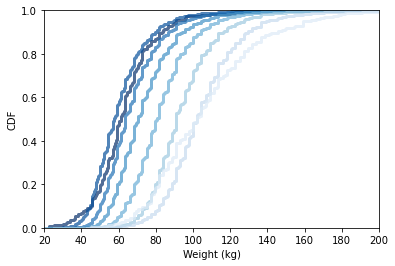

In [25]:
# Solution goes here
bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [28]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [29]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [30]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [31]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

## Exercises

# Exercise 7-1

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [32]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [33]:
# Solution goes here
ages = live.agepreg
weights = live.totalwgt_lb
print('Corr', Corr(ages, weights))
print('SpearmanCorr', SpearmanCorr(ages, weights))

Corr 0.06883397035410908
SpearmanCorr 0.09461004109658226


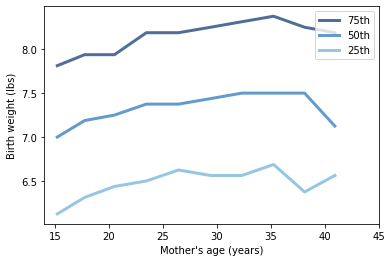

In [34]:
# Solution goes here
def BinnedPercentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)

    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age (years)",
                     ylabel='Birth weight (lbs)',
                     xlim=[14, 45], legend=True)
    
BinnedPercentiles(live)

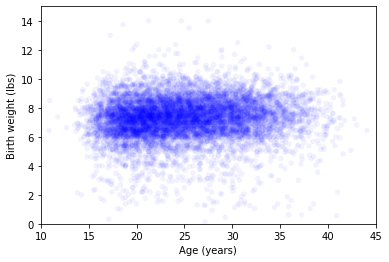

In [35]:
# Solution goes here
def ScatterPlot(ages, weights, alpha=1.0, s=20):
    """Make a scatter plot and save it.

    ages: sequence of float
    weights: sequence of float
    alpha: float
    """
    thinkplot.Scatter(ages, weights, alpha=alpha)
    thinkplot.Config(xlabel='Age (years)',
                     ylabel='Birth weight (lbs)',
                     xlim=[10, 45],
                     ylim=[0, 15],
                     legend=False)
    
ScatterPlot(ages, weights, alpha=0.05, s=10)

In [32]:
# Solution goes here
# My conclusions:

# 1) The scatterplot shows a weak relationship between the variables but
#    it is hard to see clearly.

# 2) The correlations support this.  Pearson's is around 0.07, Spearman's
#    is around 0.09.  The difference between them suggests some influence
#    of outliers or a non-linear relationsip.

# 3) Plotting percentiles of weight versus age suggests that the
#    relationship is non-linear.  Birth weight increases more quickly
#    in the range of mother's age from 15 to 25.  After that, the effect
#    is weaker.

# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


# Chapter 8

In [17]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot
import random

## The estimation game


Root mean squared error is one of several ways to summarize the average error of an estimation process.

In [18]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

The following function simulates experiments where we try to estimate the mean of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and collect the mean and median of each sample.

Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [19]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

The following function simulates experiments where we try to estimate the variance of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and two estimates for each sample, $S^2$ and $S_{n-1}^2$.

## The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [20]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

## Exercises

# Exercise 8-1

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [21]:
# Solution goes here
def Estimate4(n=7, iters=100000):
    """Mean error for xbar and median as estimators of population mean.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('mean error xbar', MeanError(means, mu))
    print('mean error median', MeanError(medians, mu))
    
Estimate4()

Experiment 1
mean error xbar -0.0005825844004785726
mean error median 0.00043440097933229645


In [22]:
# Solution goes here
def Estimate5(n=7, iters=100000):
    """RMSE for biased and unbiased estimators of population variance.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('Experiment 2')
    print('RMSE biased', RMSE(estimates1, sigma**2))
    print('RMSE unbiased', RMSE(estimates2, sigma**2))

Estimate5()

Experiment 2
RMSE biased 0.513632632281983
RMSE unbiased 0.5752358467440595


In [14]:
# Solution goes here
# My conclusions:

# 1) xbar and median yield lower mean error as m increases, so neither
# one is obviously biased, as far as we can tell from the experiment.

# 2) The biased estimator of variance yields lower RMSE than the unbiased
# estimator, by about 10%.  And the difference holds up as m increases.

# Exercise 8-2

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



standard error 0.8348150733360641
confidence interval (1.2765031909880655, 3.720222670227433)


0.8348150733360641

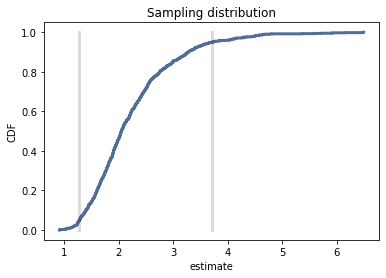

In [26]:
# Solution goes here
def SimulateSample(lam=2, n=10, iters=1000):
    """Sampling distribution of L as an estimator of exponential parameter.

    lam: parameter of an exponential distribution
    n: sample size
    iters: number of iterations
    """
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SimulateSample()

In [16]:
# Solution goes here
# My conclusions:

# 1) With sample size 10:

# standard error 0.83
# confidence interval (1.27, 3.72)

# 2) As sample size increases, standard error and the width of
#    the CI decrease:

# 10      0.83    (1.27, 3.72)
# 100     0.21    (1.72, 2.38)
# 1000    0.06    (1.9, 2.1)

# All three confidence intervals contain the actual value, 2.